Hello fellow Kagglers,

This notebook demonstrates how to pretrain a RoBERTa model on a dataset containing 1.5 million sections from simple and normal Wikipedia. This binary classification task should fine tune the RoBERTa weights to learn text features indicating its readability level.

The dataset used can be found [here](https://www.kaggle.com/markwijkhuizen/simplenormal-wikipedia-sections).

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
from statistics import harmonic_mean

from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize, sent_tokenize
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from scipy.stats import pearsonr
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import os
import sys
import nltk
import string
import math
import logging
import glob
import random
import gc

tf.get_logger().setLevel(logging.ERROR)
        
tqdm.pandas()

print(f'tensorflow version: {tf.__version__}')
print(f'tensorflow keras version: {tf.keras.__version__}')
print(f'python version: P{sys.version}')

In [ ]:
# Seed all random sources
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
set_seeds(42)

In [ ]:
# Maximum Tokenized input length
SEQ_LENGTH = 250

# Dataset is compressed and can take ~15 seconds to load
train = pd.read_pickle('/kaggle/input/simplenormal-wikipedia-sections/wikipedia_sections.pkl.xz')

In [ ]:
display(train.head())

In [ ]:
display(train.info())

# Dataset Properties

As can be observed the dataset is not balanced. This is caused by normal Wikipedia pages having far more sections than simple Wikipedia pages.

In [ ]:
plt.figure(figsize=(10, 10))
plt.ylabel('ylabel', fontsize=24)
train['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', textprops={'fontsize': 16})
plt.show()

Only section with at least 25 words are included in the dataset.

In [ ]:
# Describe word_count
display(train['word_count'].describe().apply(lambda i: int(i)))

In [ ]:
plt.figure(figsize=(15, 8))
train.loc[train['word_count'] < int(1e3), 'word_count'].plot(kind='hist', bins=32)
plt.title('Frequency per Word Count', size=24, pad=10)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Frequency', size=18, labelpad=10)
plt.ylabel('Word Count', size=18, labelpad=10)
plt.show()

# Roberta Tokenize

In [ ]:
# Define the model name
MODEL = 'roberta-base'

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained(MODEL)

In [ ]:
# This function tokenize the text according to a transformers model tokenizer
def regular_encode(excerpt):
    enc_di = tokenizer.batch_encode_plus(
        excerpt,
        padding = 'max_length',
        truncation = True,
        max_length = SEQ_LENGTH,
        return_attention_mask = False,
        return_tensors = 'np',
    )
    return enc_di['input_ids'].astype(dtype=np.uint16)

Precomputed RoBERTa tokenized texts are used, as it take forever (30m) to compute them.

In [ ]:
if os.path.exists(f'/kaggle/input/simplenormal-wikipedia-sections/wikipedia_section_roberta_input_ids_{SEQ_LENGTH}.npy'):
    train_input_ids = np.load(f'/kaggle/input/simplenormal-wikipedia-sections/wikipedia_section_roberta_input_ids_{SEQ_LENGTH}.npy')
    
    if len(train) != len(train_input_ids):
        print(f'Precomputed RoBERTa input_ids are outdated and need to be recomputed')
        print(f'New train length: {len(train)}, Precomputed RoBERTa input_ids length: {len(train_input_ids)}')
        # Compute text encoding, this will take ~30 minutes per million rows
        del train_input_ids
        train_input_ids = regular_encode(train['text'])
        # save input_ids
        np.save(f'wikipedia_section_roberta_input_ids_{SEQ_LENGTH}', train_input_ids)
        print('New RoBERTa input_ids succesfully computed and saved')
    else:
        print(f'Successfully loaded precomputed RoBERTa input_ids')
else:
    # Compute text encoding, this will take 1 hour per million rows
    train_input_ids = regular_encode(train['text'])
    # save input_ids
    np.save(f'wikipedia_section_roberta_input_ids_{SEQ_LENGTH}', train_input_ids.astype(np.uint16))

# Hardware Configuration

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy(devices=['/gpu:0']) # default distribution strategy in Tensorflow. Works on CPU and single GPU.

REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

# set half precision policy
mixed_precision.set_policy('float32')

print(f'Compute dtype: {mixed_precision.global_policy().compute_dtype}')
print(f'Variable dtype: {mixed_precision.global_policy().variable_dtype}')

# Model

A simple model is used with a RoBERTa layer, followed by a dropout layer and a classification layer. The hyper parameters for the optimizer are taken from the [RoBERTa paper](https://arxiv.org/pdf/1907.11692.pdf)

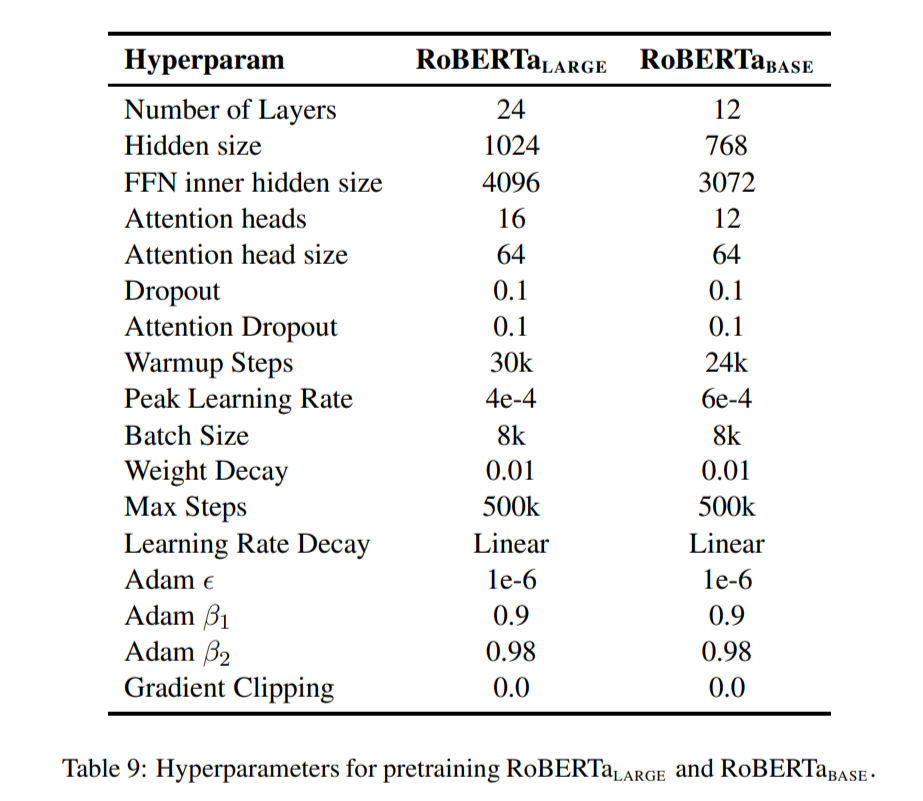

In [ ]:
def get_model():
    with strategy.scope():
        # RoBERTa
        transformer = TFRobertaModel.from_pretrained(MODEL)
        input_ids = tf.keras.layers.Input(shape = (SEQ_LENGTH), dtype=tf.int32, name='input_ids')
        sequence_output = transformer(input_ids)[0]
        # We only need the cls_token, resulting in a 2d array
        cls_token = sequence_output[:, 0, :]
        # 10% dropout
        dropout = tf.keras.layers.Dropout(0.10)(cls_token)
        # 2 output neurons for Simple and Normal class
        output = tf.keras.layers.Dense(2, activation=None, dtype=tf.float32)(dropout)
        
        model = tf.keras.models.Model(inputs = [input_ids], outputs = [output])

        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        # Parameters taken from the RoBERTa paper
        optimizer = tf.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-6)
        metrics = [
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
        ]

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)            
    
    return model

model = get_model()

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=False)

# Train configuration

A large batch size of 1024 divided over 8 compute units is used. Training is done for 5 epochs, after 5 epochs the model only overfits, which is surprising given the huge sample count.

In [ ]:
# Training configuration
BATCH_SIZE_BASE = 128
BATCH_SIZE = BATCH_SIZE_BASE * REPLICAS
EPOCHS = 5

print(f'BATCH SIZE: {BATCH_SIZE}, EPOCHS: {EPOCHS}')

# Train Test Split

50 batches of 1024 images are used for validation

In [ ]:
# We will be using 51200 (1024*50) validation sections
N_VAL = 51200
test_size = N_VAL / len(train)
X_train, X_val, y_train, y_val = train_test_split(train_input_ids, train['label_int'], test_size=test_size, random_state=42, stratify=train['label_int'])
print(f'N train samples: {len(X_train)}, N val samples: {len(X_val)}')

In [ ]:
# Check if the train/val split is correctly stratified over the classes
print('Train label distribution')
display(pd.Series(y_train).value_counts(normalize=True))
print('Val label distribution')
display(pd.Series(y_val).value_counts(normalize=True))

# Dataset

In [ ]:
def get_dataset(X, y, shuffle):    
    XX = { 
        'input_ids': X,
    }
    yy = tf.one_hot(y, 2, dtype=tf.uint8)
    
    dataset = tf.data.Dataset.from_tensor_slices((XX, yy))
    # Only shuffle for train dataset
    if shuffle:
        dataset = dataset.shuffle(len(X))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1)
    
    return dataset

In [ ]:
# TRAIN DATASET
train_dataset = get_dataset(X_train, y_train, shuffle=True)

# Example of a batch
train_x, train_y = next(iter(train_dataset))
print(f'train_x keys: {list(train_x.keys())}, train_x shape: {train_x["input_ids"].shape}')
print(f'train_x input ids dtype: {train_x["input_ids"].dtype}')
print(f'train_y shape: {train_y.shape}, train_y dtype {train_y.dtype}')
print(f'first 2 labels: {train_y[:2].numpy().tolist()}')

In [ ]:
# VAL DATASET
val_dataset = get_dataset(X_val, y_val, shuffle=False)

# Example of a batch
val_x, val_y = next(iter(val_dataset))
print(f'val_x keys: {list(val_x.keys())}, val_x shape: {val_x["input_ids"].shape}')
print(f'val_x input ids dtype: {val_x["input_ids"].dtype}')
print(f'val_y shape: {val_y.shape}, val_y dtype {val_y.dtype}')
print(f'first 2 labels: {val_y[:2].numpy().tolist()}')

# Training

The actual training is done in the next cell.

In [ ]:
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    verbose = 1,
    validation_data = val_dataset,
)

In [ ]:
# Save RoBERTa weight
for l_idx, l in enumerate(model.layers):
    print(l.name)
    if l.name == 'tf_roberta_model':
        print(f'Saving layer {l_idx} with name {l.name}')
        l.save_weights('roberta_pretrained.h5')

# Training History

Training history is plotted below.

In [ ]:
def plot_history_metric(history, metric, f_best):
    plt.figure(figsize=(15, 8))
    N_EPOCHS = len(history.history['loss'])
    x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]
    x_ticks = np.arange(1, N_EPOCHS+1)
    val = 'val' in ''.join(history.history.keys())
    # summarize history for accuracy
    plt.plot(x_ticks, history.history[metric])
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='red', s=50, marker='o')
        plt.plot(x_ticks, val_values)
    
    plt.title(f'Model {metric}', fontsize=24)
    plt.ylabel(metric, fontsize=18)
    plt.xlabel('epoch', fontsize=18)
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    plt.legend(['train'] + ['val'] if val else ['train'],  prop={'size': 18})
    plt.grid()

In [ ]:
plot_history_metric(history, 'loss', np.argmin)

In [ ]:
plot_history_metric(history, 'accuracy', np.argmax)

In [ ]:
plot_history_metric(history, 'precision', np.argmax)

In [ ]:
plot_history_metric(history, 'recall', np.argmax)

In [ ]:
# F1 score or computed as the harmonic mean of precision and recall
def hmean_element_wise(aa, bb):
    return [harmonic_mean([a, b]) for a, b in zip(aa, bb)]

history.history['F1'] = hmean_element_wise(history.history['precision'], history.history['recall'])
history.history['val_F1'] = hmean_element_wise(history.history['val_precision'], history.history['val_recall'])

plot_history_metric(history, 'F1', np.argmax)

# Confusion Matrix

Due to the inbalanced dataset the confusion matrix give important insights in the actual performance of the model. The simple Wikipedia class has a recall close to 80\%, which gives confidence in the model actually learning to distinguish simple from normal Wikipedia sections and not only getting biased towards the majority class.

In [ ]:
def plot_validation_report_per_class(model, dataset):
    print(f'--- CLASSIFICATION REPORT ---')
    # classification report
    bs = BATCH_SIZE
    y = np.ndarray(shape=len(val_dataset) * bs, dtype=np.uint16)
    y_pred = np.ndarray(shape=len(val_dataset) * bs, dtype=np.uint16)
    for idx, (images, labels) in tqdm(enumerate(dataset), total=len(dataset)):
        with tf.device('cpu:0'):
            y[idx*bs:(idx+1)*bs] = np.argmax(labels, axis=1)
            y_pred[idx*bs:(idx+1)*bs] = np.argmax(model.predict(images).astype(np.float32), axis=1)
            
    print(classification_report(y, y_pred))
    
    # Confusion matrix
    N_LABELS = 2
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    cfn_matrix = confusion_matrix(y, y_pred, labels=range(N_LABELS))
    cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T
    df_cm = pd.DataFrame(cfn_matrix, index=np.arange(N_LABELS), columns=np.arange(N_LABELS))
    ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.3f', linewidths=.5, annot_kws={'size':14}).set_title('CONFUSION MATRIX')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('PREDICTED', fontsize=24, labelpad=10)
    plt.ylabel('ACTUAL', fontsize=24, labelpad=10)
    plt.show()

In [ ]:
plot_validation_report_per_class(model, val_dataset)

# CommonLit Model

The next function shows how the pretrained RoBERTa model can be loaded into a model for the CommonLit training task.

In [ ]:
def get_model():
    tf.keras.backend.clear_session()

    with strategy.scope():
        # RoBERTa
        transformer = TFRobertaModel.from_pretrained(MODEL)
        # Load saved weights
        transformer.load_weights('roberta_pretrained.h5')
        
        input_ids = tf.keras.layers.Input(shape = (SEQ_LENGTH), dtype=tf.int32, name='input_ids')
        sequence_output = transformer(input_ids)[0]
        # We only need the cls_token, resulting in a 2d array
        cls_token = sequence_output[:, 0, :]
        output = tf.keras.layers.Dense(1, activation='linear', dtype=tf.float32)(cls_token)
        
        # Model
        model = tf.keras.models.Model(inputs=input_ids, outputs=output)

        loss = tf.keras.losses.MeanSquaredError()
        optimizer = tf.optimizers.Adam(learning_rate=4e-5)
        metrics = [
            tf.keras.metrics.RootMeanSquaredError(name='RMSE'),
        ]

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

model = get_model()

In [ ]:
model.summary()